In [1]:
# %matplotlib inline
from skimage import color, data, restoration
import scipy.fftpack as fp
from skimage.measure import compare_psnr
from skimage.io import imread
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage.io import imread

def convolve2d(im, psf, k):
    M, N = im.shape
    freq = fp.fft2(im)
    psf = np.pad(psf, (((M-k)//2,(M-k)//2+1), ((N-k)//2,(N-k)//2+1)), mode='constant') # assumption: min(M,N) > k > 0, k odd
    freq_kernel = fp.fft2(fp.ifftshift(psf))
    return np.abs(fp.ifft2(freq*freq_kernel))


(1260, 1024) (81, 81)


(<AxesSubplot:title={'center':'Degraded Image'}>,
 (-0.5, 1023.5, 1259.5, -0.5),
 Text(0.5, 1.0, 'Degraded Image'))

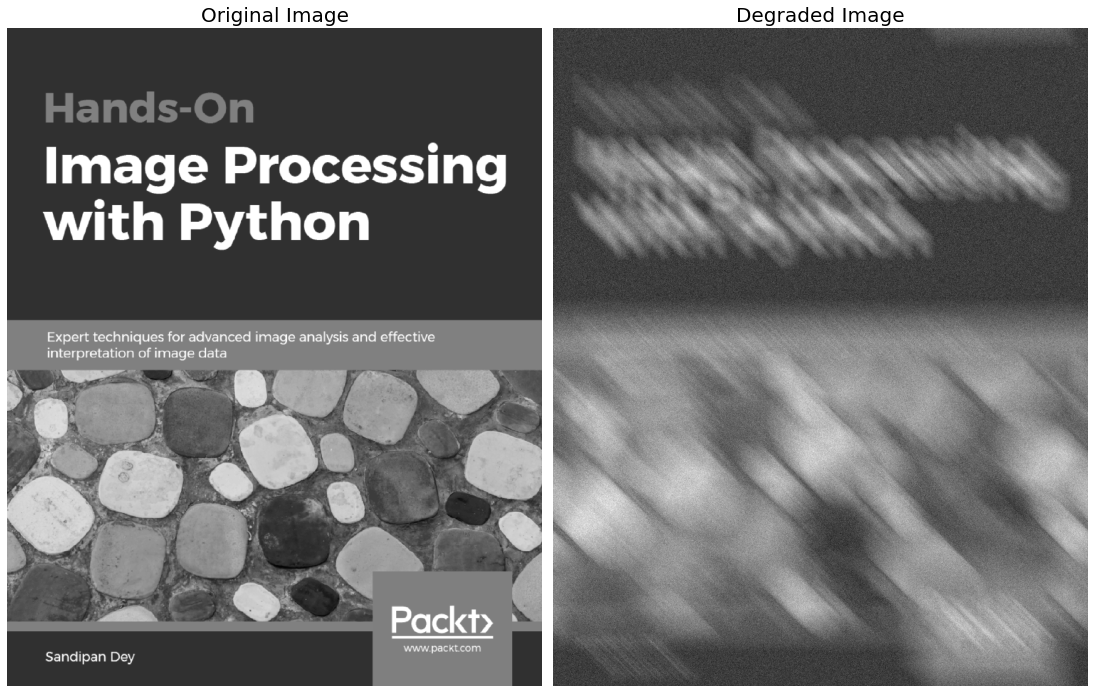

In [3]:
im = rgb2gray(imread('../data/book.png')) 
(M, N), k = im.shape, 81 # a 21 x 21 motion blurred kernel
kernel = np.zeros((k, k))
for i in range(k):
    kernel[i, i] = 1
kernel = kernel / k
#print(kernel)
print(im.shape, kernel.shape)
im_blur = convolve2d(im, kernel, k) #, mode='same')
im_blur = random_noise(im_blur, var=0.0025)


plt.figure(figsize=(15,20))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.02,0.04)
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(222), plt.imshow(im_blur), plt.axis('off'), plt.title('Degraded Image', size=20)

In [6]:

from skimage.restoration import wiener, unsupervised_wiener

# Constrained Least Squares (CLS) filter
def cls_filter(y,h,c,lambd):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf = np.conj(Hf) / (Hf*np.conj(Hf) + lambd*Cf*np.conj(Cf))
    #Hf = np.abs(Hf)**2 / (np.abs(Hf)**2 + lambd*np.abs(Cf)**2)
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return (im, Hf) 

x = im
y = im_blur
h = kernel

print("h.shape=", h.shape)
h = np.pad(h, [(M//2-k//2, M//2-k//2-1), (N//2-k//2, N//2-k//2-1)], mode='constant')
print("h.shape=", h.shape)
print("x.shape=", x.shape)


h.shape= (81, 81)
h.shape= (1260, 1024)
x.shape= (1260, 1024)


(<matplotlib.image.AxesImage at 0x7f14d9fe84d0>,
 (-0.5, 1023.5, 1259.5, -0.5),
 Text(0.5, 1.0, 'Restored Image (with Wiener) PSNR: 19.249'))

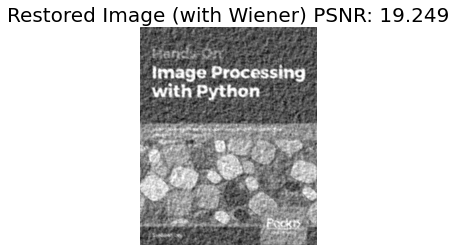

In [7]:

# restoration using wiener filtering
wx = wiener(y, h, balance=0.1)
plt.imshow(wx), plt.axis('off'), plt.title('Restored Image (with Wiener) PSNR: {}'.format(np.round(compare_psnr(x, wx),3)), size=20)


(<AxesSubplot:title={'center':'Restored Image (with CLS, $\\lambda=$7.5) PSNR: 20.986'}>,
 (-0.5, 1023.5, 1259.5, -0.5),
 Text(0.5, 1.0, 'Restored Image (with CLS, $\\lambda=$7.5) PSNR: 20.986'))

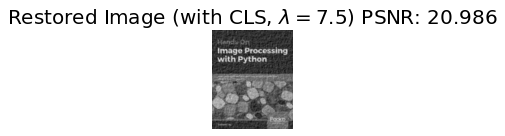

In [8]:
# restoration using cls filtering
c =  np.array([[0,1/4,0],[1/4,-1,1/4],[0,1/4,0]])
c = np.pad(c, [(M//2-1, M//2-2), (N//2-2, N//2-1)], mode='constant')
Cf = fp.fft2(fp.ifftshift(c))
lambd = 7.5
clx, F_restored = cls_filter(y, h, c, lambd)
plt.subplot(224), plt.imshow(clx), plt.axis('off'), plt.title(r'Restored Image (with CLS, $\lambda=${}) PSNR: {}'.format(lambd, np.round(compare_psnr(x, clx),3)), size=20)

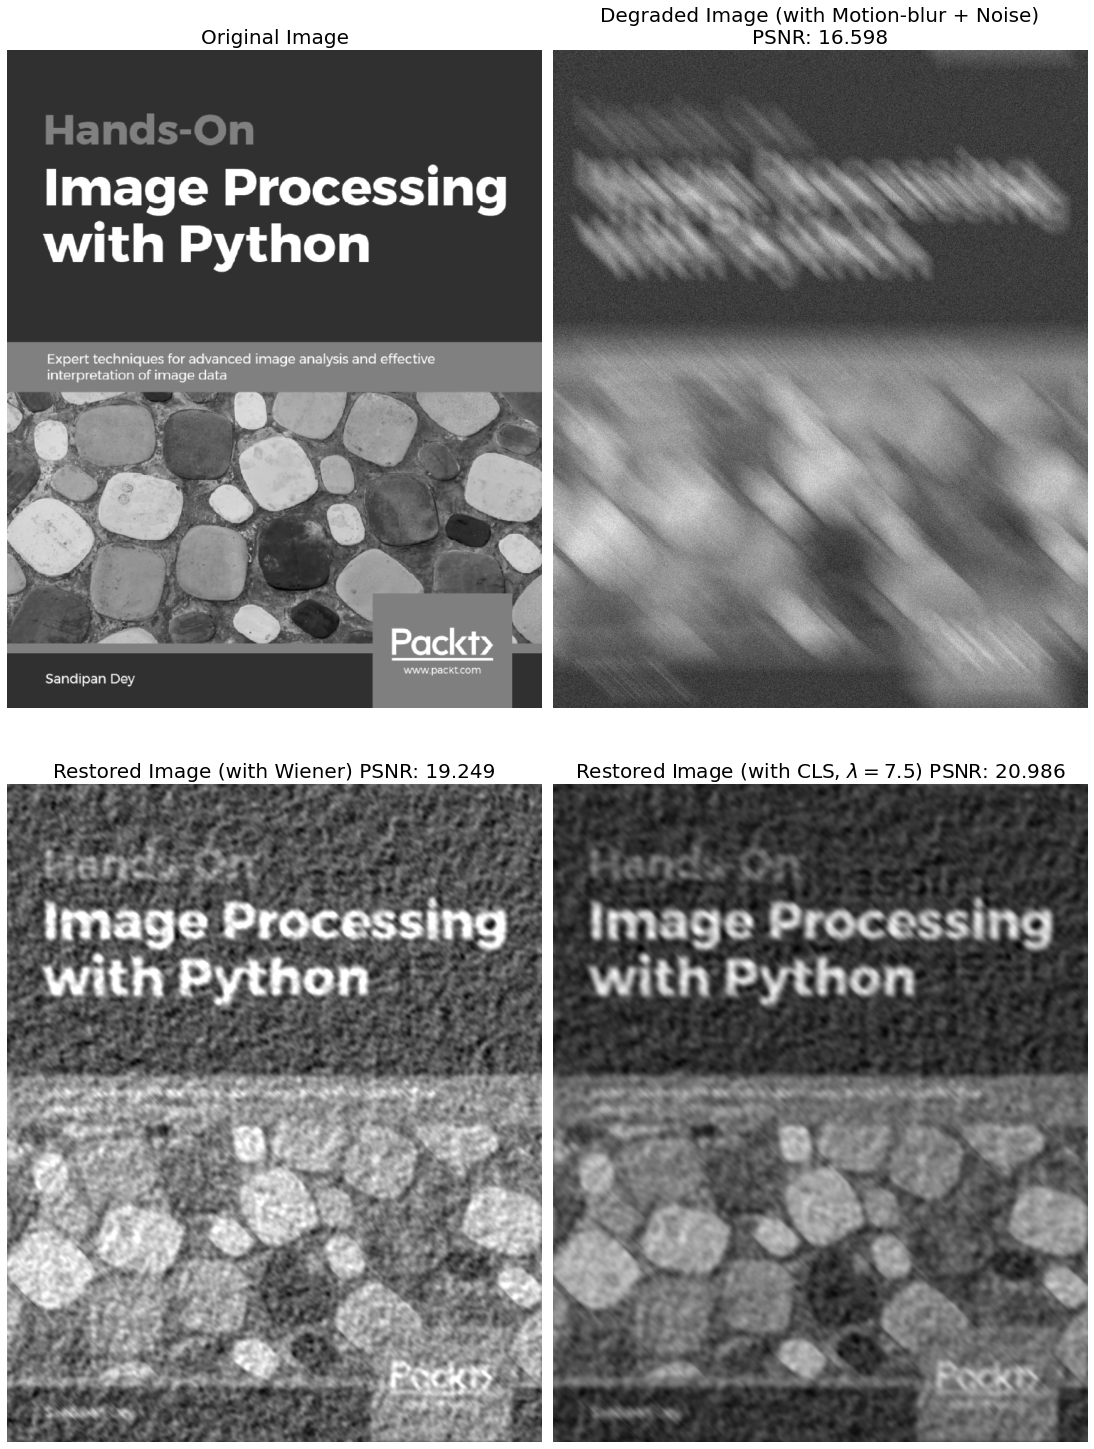

In [9]:
plt.figure(figsize=(15,20))
plt.gray()
plt.subplots_adjust(0,0,1,1,0.02,0.04)
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(222), plt.imshow(im_blur), plt.axis('off'), plt.title('Degraded Image (with Motion-blur + Noise)\nPSNR: {}'.format(np.round(compare_psnr(x, y),3)), size=20)
plt.subplot(223), plt.imshow(wx), plt.axis('off'), plt.title('Restored Image (with Wiener) PSNR: {}'.format(np.round(compare_psnr(x, wx),3)), size=20)
plt.subplot(224), plt.imshow(clx), plt.axis('off'), plt.title(r'Restored Image (with CLS, $\lambda=${}) PSNR: {}'.format(lambd, np.round(compare_psnr(x, clx),3)), size=20)
plt.show()